In [2]:
import io
import PIL
import cv2
import json
import base64
import requests
import numpy as np
import PIL.ImageDraw
import PIL.ImageFont

In [29]:
class ModelServices():
    def __init__(self, iServers_config = None):
        self.servers_config = iServers_config if iServers_config else {}
    
    def encode_np_array(self, iArray : np.array):
        vBuffer = io.BytesIO()
        np.save(vBuffer, iArray)
        vBuffer.seek(0)
        return base64.b64encode(vBuffer.read()).decode('utf-8')

    def decode_np_array(self, iEncodedArray : str):
        vArray = iEncodedArray.encode('utf-8')
        vArray = base64.b64decode(vArray)
        vBuffer = io.BytesIO(vArray)
        return np.load(vBuffer)
    
    def set_detect_objects_server(self, iModel_url):
        self.servers_config["detect_objects"] = iModel_url

    def set_clip_server(self, iModel_url):
        self.servers_config["clip"] = iModel_url
    
    def set_open_pose_server(self, iModel_url):
        self.servers_config["open_pose"] = iModel_url
    
    def set_mls_server(self, iModel_url):
        self.servers_config["mls"] = iModel_url

    def set_mls_controlnet_server(self, iModel_url):
        self.servers_config["mls_controlnet"] = iModel_url
    
    def set_sam_server(self, iModel_url):
        self.servers_config["sam"] = iModel_url

    def detect_objects(self, iImage : np.array, iSearched_label : list = list(), iMinScore : float = 0.9, iMinArea : float = 0):
        vImageBase64 = self.encode_np_array(iImage)
        vResponse = requests.post(
            self.servers_config["detect_objects"] + "/genera/object_detection",
            json = {"image": vImageBase64, "threshold": iMinScore}
        )
        vResponse = vResponse.json()["data"]
        vFilteredResult = [x for x in vResponse \
            if iSearched_label is None or x["label_name"] in iSearched_label or len(iSearched_label) == 0
        ]
        for tResult in vFilteredResult:
            tResult["box"] = [round(x) for x in tResult["box"]]
            tResult["box"] = [(x if x >= 0 else 0) for x in tResult["box"]]
            tResult["centroid"] = (
                (tResult["box"][0] + tResult["box"][2])//2,
                (tResult["box"][1] + tResult["box"][3])//2
            )
            tResult["area"] = (tResult["box"][2] - tResult["box"][0]) * (tResult["box"][3] - tResult["box"][1])
            tResult["area"] = tResult["area"] / (iImage.shape[0] * iImage.shape[1])
        
        vFilteredResult = [ x for x in vFilteredResult if x["area"] >= iMinArea]
        return vFilteredResult

    def generate_clip(self, iImage : np.array, iTags : list):
        vImageBase64 = self.encode_np_array(iImage)
        vResponse = requests.post(
            self.servers_config["clip"] + "/genera/clip",
            json = {"image": vImageBase64, "tags": iTags}
        )
        return [ _ for _ in zip(iTags, vResponse.json()["data"])]

    def generate_open_pose(self, iImage : np.array):
        vImageBase64 = self.encode_np_array(iImage)
        vResponse = requests.post(
            self.servers_config["open_pose"] + "/genera/open_pose",
            json = {"image": vImageBase64}
        )
        vImg = self.decode_np_array(vResponse.json()["data"])
        return vImg

    def generate_mls(self, iImage : np.array):
        vImageBase64 = self.encode_np_array(iImage)
        vResponse = requests.post(
            self.servers_config["mls"] + "/genera/mlsd",
            json = {"image": vImageBase64}
        )
        vImg = self.decode_np_array(vResponse.json()["data"])
        return vImg

    def generate_mls_controlnet(self, iImage : np.array, iPrompt):
        vImageBase64 = self.encode_np_array(iImage)
        vResponse = requests.post(
            self.servers_config["mls_controlnet"] + "/genera/controlnet/mlsd",
            json = {"image": vImageBase64, "prompt": iPrompt}
        )
        vImg = self.decode_np_array(vResponse.json()["data"])
        return vImg

    def generate_sam_mask_by_box(self, iImage : np.array, iBoxes):
        vImageBase64 = self.encode_np_array(iImage)
        vResponse = requests.post(
            self.servers_config["sam"] + "/genera/sam/boxes",
            json = {"image": vImageBase64, "boxes": iBoxes}
        )
        vMasks = vResponse.json()["data"]
        vMasks = [self.decode_np_array(x) for x in vMasks]
        return vMasks

gAIServer = ModelServices()
gAIServer.set_detect_objects_server("http://localhost:88")
gAIServer.set_clip_server("http://localhost:88")
gAIServer.set_open_pose_server("http://localhost:88")
gAIServer.set_mls_server("http://localhost:88")
gAIServer.set_sam_server("http://localhost:88")
gAIServer.set_mls_controlnet_server("http://7e0e-35-184-192-66.ngrok.io")

In [4]:
import matplotlib.pyplot as plt

def plot_images(iImages, iFigSize=(5, 5)):
    if isinstance(iFigSize, int):
        iFigSize = (iFigSize, iFigSize)
        
    if isinstance(iImages, list) and len(iImages) > 1:
        _, vAxisArray = plt.subplots(1, len(iImages), figsize=iFigSize)
        for i, tImage in enumerate(iImages):
            vAxisArray[i].imshow(tImage)
            vAxisArray[i].axis('off')
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
        plt.show()
    else:
        vImage = iImages[0] if isinstance(iImages, list) and len(iImages) == 1 else iImages
        _, ax = plt.subplots(figsize=iFigSize)
        ax.imshow(vImage)
        ax.axis('off')
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        plt.show()

In [5]:
def track_objects_by_distance(iObjectsTracked, iCurrentBoxes, iMaxDistance):
    vDistance = list()
    for tPrev in iObjectsTracked:
        for tCurr in iCurrentBoxes:
            d_p1 = ( (tCurr[0] - tPrev[0]) ** 2 + (tCurr[1] - tPrev[1]) ** 2 ) ** 0.5
            d_p2 = ( (tCurr[0] - tPrev[0]) ** 2 + (tCurr[3] - tPrev[3]) ** 2 ) ** 0.5
            d_p3 = ( (tCurr[2] - tPrev[2]) ** 2 + (tCurr[1] - tPrev[1]) ** 2 ) ** 0.5
            d_p4 = ( (tCurr[2] - tPrev[2]) ** 2 + (tCurr[3] - tPrev[3]) ** 2 ) ** 0.5
            d_pC = ( (tCurr[4] - tPrev[4]) ** 2 + (tCurr[5] - tPrev[5]) ** 2 ) ** 0.5

            d_pC = (d_p1 + d_p2 + d_p3 + d_p4 + d_pC)/5
            vDistance.append([tPrev[6], tCurr[6], d_pC])
    
    vDistance.sort(key = lambda x : x[2], reverse = False)
    vPreObj = list()
    vNewObj = list()
    vIndex = 0
    for tD in vDistance:
        vOldIndex = tD[0]
        vNewIndex = tD[1]
        if tD[2] > iMaxDistance:
            break
        if vOldIndex not in vPreObj and vNewIndex not in vNewObj:
            vPreObj.append(vOldIndex)
            vNewObj.append(vNewIndex)
            iObjectsTracked[vOldIndex] = iCurrentBoxes[vNewIndex]
            iObjectsTracked[vOldIndex][6] = vOldIndex
            iObjectsTracked[vOldIndex][7] = 0
        vIndex = vIndex + 1
    
    vMissingObject = [ x for x in iObjectsTracked if x[6] not in vPreObj]
    for tObj in vMissingObject:
        tObj[7] = tObj[7] + 1

    vNewObjects = [x for i, x in enumerate(iCurrentBoxes) if i not in vNewObj]
    vNewObjects = [[x[0], x[1], x[2], x[3], x[4], x[5], i] for i, x in enumerate(vNewObjects)]
    vNewObjects = [[x0, y0, x1, y1, cx, cy, len(iObjectsTracked) + i, 0] for x0, y0, x1, y1, cx, cy, i in vNewObjects]
    iObjectsTracked.extend(vNewObjects)

In [6]:
def draw_boxes(iImage : np.array, iBoxes, iWidth, iMinTimeDetected, iIndexFrame):
    vImage = PIL.Image.fromarray(iImage)
    vDraw = PIL.ImageDraw.Draw(vImage)
    vColors = ["red", "blue", "green", "cyan", "yellow", "black", "orange", "pink", "white", "white"]

    for i, tBox in enumerate(iBoxes):
        if tBox[7] <= iMinTimeDetected:
            vDraw.rectangle(tBox[:4], outline = vColors[i], width = iWidth)
            vDraw.ellipse(
                    (   tBox[4] - iWidth,
                        tBox[5] - iWidth,
                        tBox[4] + iWidth,
                        tBox[5] + iWidth
                    ),
                    outline = vColors[i],
                    width = iWidth
                )
            vDraw.text((tBox[4], tBox[5]), "Id: " + str(tBox[6]) + ">>" + str(tBox[7]), (255, 255, 255))
    
    vDraw.text((5, 5), "Frame: " + str(iIndexFrame), (255, 255, 255))
    return np.array(vImage)

def write_frame_index(iImage : np.array, iIndexFrame):
    vImage = PIL.Image.fromarray(iImage)
    vDraw = PIL.ImageDraw.Draw(vImage)
    vDraw.text((5, 5), "Frame: " + str(iIndexFrame), (255, 255, 255))
    return np.array(vImage)

In [7]:
def crop_image(iImage, iBox):
    vImage = iImage[ iBox[1] : iBox[3] , iBox[0] : iBox[2]]
    return vImage

def clip_filter(iImage : np.array, iBoxes : list, iMinPersonScore : float = 0.8):
    vNewBoxes = list()
    for tBox in iBoxes:
        vNewImage = crop_image(iImage, tBox)
        vClipResponse = gAIServer.generate_clip(vNewImage, ["person", "cat", "car"])[0][1]
        if vClipResponse >= iMinPersonScore:
            tBox[6] = len(vNewBoxes)
            vNewBoxes.append(tBox)
    return vNewBoxes

def get_pixel_change(iImgA : np.array, iImgB : np.array):
    vDiferences = abs(iImgA.astype(np.float32) - iImgB.astype(np.float32))
    vDiferences = vDiferences / 255
    vNormalImage = np.linalg.norm(vDiferences, axis = 2)
    vNormalImage = vNormalImage / np.sqrt(3)
    return vNormalImage.mean(), vNormalImage

def get_objects_detected(iVideoFilePath, iStartFrame, iEndFrame):
    vVideoCapture = cv2.VideoCapture(iVideoFilePath)
    vBoxesDetected = list()
    try:
        vVideoCapture.set(cv2.CAP_PROP_POS_FRAMES, iStartFrame) # Set the first frame to process in the video.
        vIndexFrame = iStartFrame if iStartFrame is not None else 0 # Assign the frame index.
        vSucces, vFrame = vVideoCapture.read()
        vPreviousFrame = vFrame
        while vSucces and (iEndFrame is None or vIndexFrame <= iEndFrame):
            print(f"\r> Processing frame {vIndexFrame}: ", end = "")
            vFrame = cv2.cvtColor(vFrame, cv2.COLOR_BGR2RGB)
            #vBoxes = gAIServer.detect_objects(vFrame, ["person"], 0.9, 0.05)
            vME, _ = get_pixel_change(vPreviousFrame, vFrame)
            vBoxes = None
            vBoxesDetected.append({
                "frame_id": vIndexFrame,
                "boxes": vBoxes,
                "me": float(vME)
            })
            vIndexFrame = vIndexFrame + 1
            vSucces, vFrame = vVideoCapture.read()
    finally:
        vVideoCapture.release()
        print("")
    return vBoxesDetected

def get_tracking_by_distance(iVideoFilePath, iListBoxes, iStartFrame, iEndFrame):
    vObjectsTracked = list()
    vIndexFrame = iStartFrame if iStartFrame is not None else 0 # Assign the frame index.
    vMaxDistance = 150
    vMaxDisapeer = 10
    while vIndexFrame < len(iListBoxes) and (iEndFrame is None or vIndexFrame <= iEndFrame):
        print(f"\r> Processing frame {vIndexFrame}: ", end = "")
        vBoxes = iListBoxes[vIndexFrame]["boxes"]
        vCurrentBoxes = [[x["box"][0], x["box"][1], x["box"][2], x["box"][3],
            x["centroid"][0], x["centroid"][1], i, 0] for i, x in enumerate(vBoxes)]
        #vCurrentBoxes = clip_filter(vFrame, vCurrentBoxes, 0.5)
        track_objects_by_distance(vObjectsTracked, vCurrentBoxes, vMaxDistance)
        vIndexFrame = vIndexFrame + 1
    print("")
    return vObjectsTracked


Frame rate of the source video is 24.0
FOURCC: 828601953
Width  of the source video is 1280
Height of the source video is 720
Total frames of the video is 360
Target width  is 1280
Target height is 720
> Processing frame 31/31: 

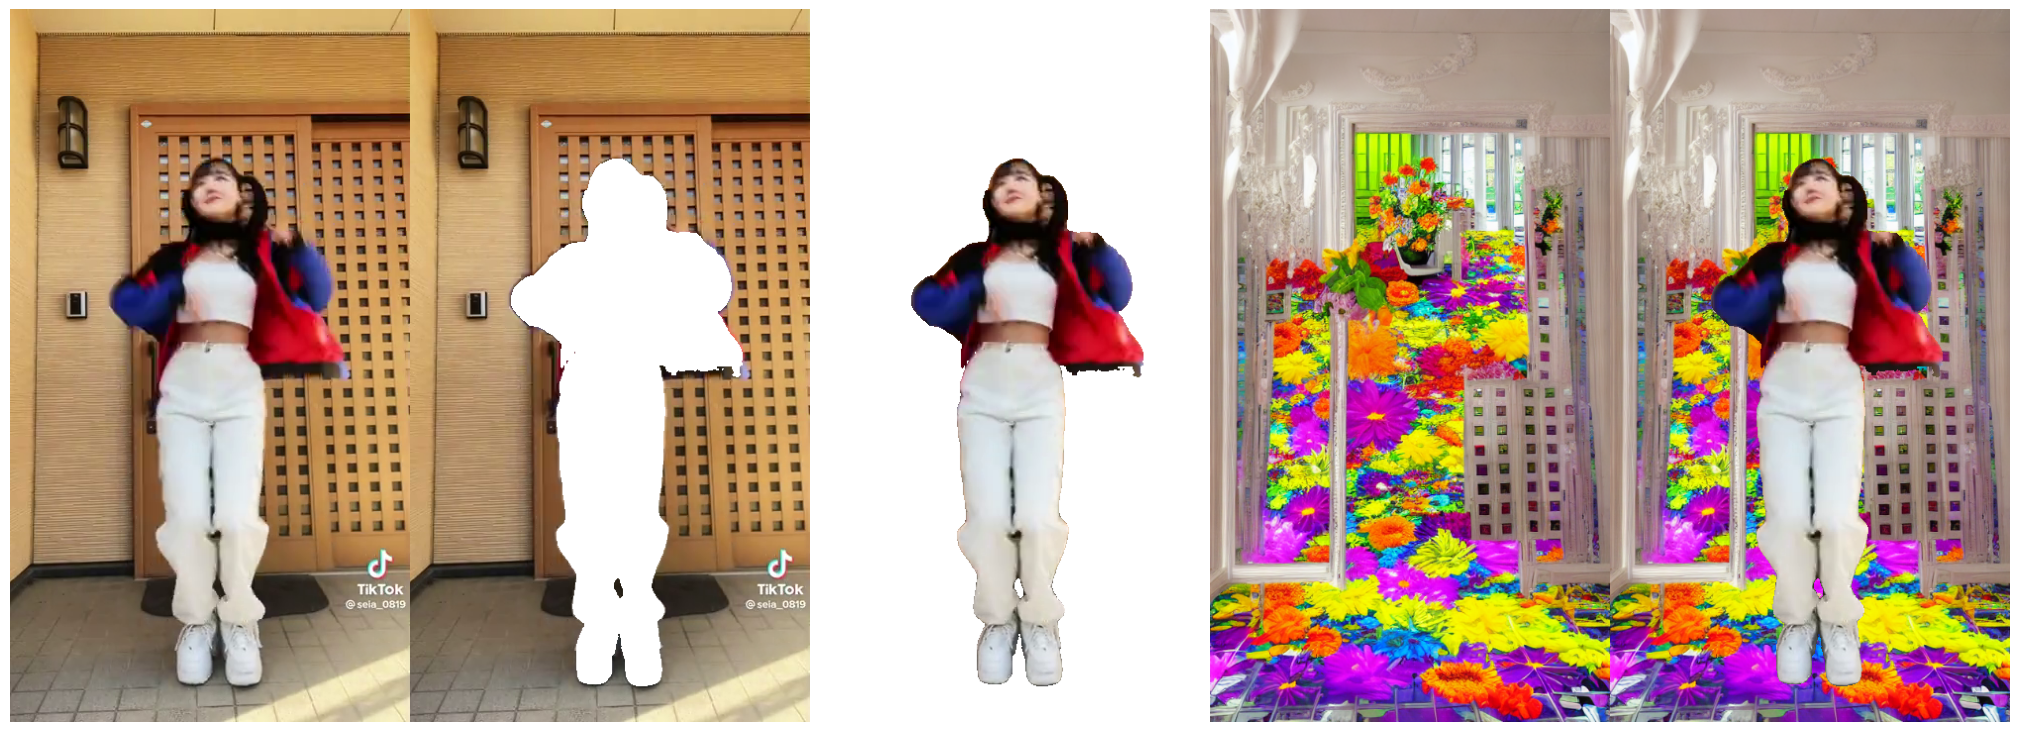

In [31]:
def video2video(iVideoFilePath, iNewVideoFilePath, iStartFrame, iEndFrame, iCallBack, iWidth, iHeight, ** kwargs):
    vVideoCapture = cv2.VideoCapture(iVideoFilePath)                    # Open the video file.
    vFrameRate    = vVideoCapture.get(cv2.CAP_PROP_FPS)                 # Obtain the frame rate.
    vFourcc       = int(vVideoCapture.get(cv2.CAP_PROP_FOURCC))         # Obtain the FOURCC (Four Character Code).
    vVideoWidth   = int(vVideoCapture.get(cv2.CAP_PROP_FRAME_WIDTH))    # Obtain the Width  of the video.
    vVideoHeight  = int(vVideoCapture.get(cv2.CAP_PROP_FRAME_HEIGHT))   # Obtain the Height of the video.
    vTotalFrames  = int(vVideoCapture.get(cv2.CAP_PROP_FRAME_COUNT))    # Obtain the count of frames of the source video.
    
    print(f"Frame rate of the source video is {vFrameRate}")
    print(f"FOURCC: {vFourcc}")
    print(f"Width  of the source video is {vVideoWidth}")
    print(f"Height of the source video is {vVideoHeight}")
    print(f"Total frames of the video is {vTotalFrames}")
    
    iWidth  = iWidth  if iWidth  is not None else vVideoWidth
    iHeight = iHeight if iHeight is not None else vVideoHeight
    iEndFrame = iEndFrame if iEndFrame is not None else vTotalFrames
    iEndFrame = vTotalFrames if iEndFrame > vTotalFrames else iEndFrame

    print(f"Target width  is {iWidth}")
    print(f"Target height is {iHeight}")
    vVideoWriter  = cv2.VideoWriter(iNewVideoFilePath, vFourcc, vFrameRate, (iWidth, iHeight))
    vState = {}
    try:
        vIndexFrame = iStartFrame if iStartFrame is not None else 0 # Assign the frame index.
        vVideoCapture.set(cv2.CAP_PROP_POS_FRAMES, vIndexFrame)     # Set the first frame to process in the video.
        vSucces, vFrame = vVideoCapture.read()
        while vSucces and (vIndexFrame <= iEndFrame):
            print(f"\r> Processing frame {vIndexFrame+1}/{iEndFrame+1}: ", end = "")
            vNewImage, vState = iCallBack(vFrame, vIndexFrame, vState, ** kwargs)
            
            if vNewImage.shape[0] != iHeight or vNewImage.shape[1] != iWidth:
                vNewWidth  = vNewImage.shape[1]
                vNewHeight = vNewImage.shape[0]
                raise ValueError(f"Invalid frame dimensions, waiting ({iWidth}, {iHeight}) but find ({vNewWidth}, {vNewHeight}).")
            
            vVideoWriter.write(vNewImage)
            vSucces, vFrame = vVideoCapture.read()
            vIndexFrame = vIndexFrame + 1
    finally:
        vVideoCapture.release()
        vVideoWriter.release()
        print("")
    return vState

def generate_mean_error_frame(iFrame, iIndexFrame, iState, ** kwargs):
    iFrame = cv2.cvtColor(iFrame, cv2.COLOR_BGR2RGB)
    if "previous_frame" not in iState:
        iState["previous_frame"] = iFrame
    
    _, vNoiseImage = get_pixel_change(iFrame, iState["previous_frame"])
    vNoiseImage = vNoiseImage*255
    vNoiseImage = vNoiseImage.astype(np.uint8)
    iState["previous_frame"] = iFrame
    return cv2.cvtColor(vNoiseImage, cv2.COLOR_GRAY2BGR), iState

def generate_open_pose_frame(iFrame, iIndexFrame, iState, ** kwargs):
    iFrame = cv2.cvtColor(iFrame, cv2.COLOR_BGR2RGB)
    iFrame = gAIServer.generate_open_pose(iFrame)
    return cv2.cvtColor(iFrame, cv2.COLOR_RGB2BGR), iState

def generate_track_frame_by_distance(iFrame, iIndexFrame, iState, ** kwargs):
    if "objects_tracked" not in iState:
        iState["objects_tracked"] = list()
    vMaxDistance = 150
    vMaxDisapeer = 10
    iObjectsDetected = kwargs.get("iObjectsDetected")
    iFrame = cv2.cvtColor(iFrame, cv2.COLOR_BGR2RGB)

    if iObjectsDetected[iIndexFrame]["me"] > 0.13:
        iState["objects_tracked"] = list()

    vBoxes = iObjectsDetected[iIndexFrame]["boxes"]
    vCurrentBoxes = [[x["box"][0], x["box"][1], x["box"][2], x["box"][3],
        x["centroid"][0], x["centroid"][1], i, 0] for i, x in enumerate(vBoxes)]
    track_objects_by_distance(iState["objects_tracked"], vCurrentBoxes, vMaxDistance)
    iFrame = draw_boxes(iFrame, iState["objects_tracked"], 5, vMaxDisapeer, iIndexFrame)

    return cv2.cvtColor(iFrame, cv2.COLOR_RGB2BGR), iState

def get_pose_of_video(iIndexFrame):
    vVideoCapture = cv2.VideoCapture("../resources/videos/open_pose_video.mp4")
    vVideoCapture.set(cv2.CAP_PROP_POS_FRAMES, iIndexFrame)
    _, vFrame = vVideoCapture.read()
    vVideoCapture.release()
    return cv2.cvtColor(vFrame, cv2.COLOR_BGR2RGB)

def draw_box(iImage : np.array, iBox, iCentroid, iColor, iWidth, iText = None):
    vImage = PIL.Image.fromarray(iImage)
    vDraw = PIL.ImageDraw.Draw(vImage)
    vDraw.rectangle(iBox, outline = iColor, width = iWidth)
    vDraw.ellipse(
            (   iCentroid[0] - iWidth,
                iCentroid[1] - iWidth,
                iCentroid[0] + iWidth,
                iCentroid[1] + iWidth
            ),
            outline = iColor,
            width = iWidth
        )
    if iText is not None:
        vDraw.text(iCentroid, "Id: " + iText, iColor)
    return np.array(vImage)

def reshape_obj(iImgShape : np.array, iPoseShape : np.array, iObj):
    vBox = [
        int( iObj["box"][0] * (iPoseShape[1] / iImgShape[1]) ),
        int( iObj["box"][1] * (iPoseShape[0] / iImgShape[0]) ),
        int( iObj["box"][2] * (iPoseShape[1] / iImgShape[1]) ),
        int( iObj["box"][3] * (iPoseShape[0] / iImgShape[0]) )
    ]
    vCentroid = [
        int( iObj["centroid"][0] * (iPoseShape[1] / iImgShape[1]) ),
        int( iObj["centroid"][1] * (iPoseShape[0] / iImgShape[0]) )
    ]
    return vBox, vCentroid

def area_between_box(iBoxA, iBoxB):
    # Encuentra las coordenadas del cuadrado de intersección
    x1 = max(iBoxA[0], iBoxB[0])
    y1 = max(iBoxA[1], iBoxB[1])
    x2 = min(iBoxA[2], iBoxB[2])
    y2 = min(iBoxA[3], iBoxB[3])

    # Calcula la longitud y la altura del cuadrado de intersección
    vIntersectionWidth  = x2 - x1
    vIntersectionHeight = y2 - y1

    # Si los cuadrados no se superponen, el área de intersección será 0
    if vIntersectionWidth < 0 or vIntersectionHeight < 0:
        return 0
    return vIntersectionWidth * vIntersectionHeight

def area_relation_between_boxes(iBoxA, iBoxB):
    vIntersectArea = area_between_box(iBoxA, iBoxB)
    vPrevArea = (iBoxA[2] - iBoxA[0])*(iBoxA[3] - iBoxA[1]) - vIntersectArea
    vCurrArea = (iBoxB[2] - iBoxB[0])*(iBoxB[3] - iBoxB[1]) - vIntersectArea
    return vIntersectArea/(vPrevArea + vCurrArea + vIntersectArea)

def generate_track_frame_by_box_area(iFrame, iIndexFrame, iState, ** kwargs):
    iFrame = cv2.cvtColor(iFrame, cv2.COLOR_BGR2RGB)
    iCurrentObj = kwargs.get("iObjectsDetected")[iIndexFrame]["boxes"]
    iMeanError  = kwargs.get("iObjectsDetected")[iIndexFrame]["me"]
    vLimitDisapeer = 10
    vMinRelation = 0.3
    for i, tObj in enumerate(iCurrentObj):
        tObj["id"] = i
        tObj["color"] = np.random.randint(100, 256, size=3)
        tObj["color"] = (tObj["color"][0], tObj["color"][1], tObj["color"][2])
        tObj["count_disapeer"] = 0
    if "previous_objects" not in iState or iMeanError > 0.15:
        iState["previous_frame"]   = iFrame
        iState["previous_objects"] = iCurrentObj
    
    iPreviousObj = iState["previous_objects"]
    vPreviousFrame = iState["previous_frame"]
    vFrame = iFrame.copy()

    vResultIntersection = list()
    for i, tPrevObj in enumerate(iPreviousObj):
        for j, tCurrObj in enumerate(iCurrentObj):
            vAreaRelation = area_relation_between_boxes(tPrevObj["box"], tCurrObj["box"])
            if vAreaRelation >= vMinRelation:
                vResultIntersection.append({
                    "prev_obj": tPrevObj,
                    "curr_obj": tCurrObj,
                    "prev_id": i,
                    "curr_id": j,
                    "area_relation": vAreaRelation
                })
    
    vOrderedResult = sorted(vResultIntersection, key = lambda x : x["area_relation"], reverse = True)
    vCurrBoxProcessed = list()
    vPrevBoxProcessed = list()
    vNewObjectsDetected = list()
    for x in vOrderedResult:
        if x["prev_id"] not in vPrevBoxProcessed and x["curr_id"] not in vCurrBoxProcessed:
            vNewObjectsDetected.append(x)
            vCurrBoxProcessed.append(x["curr_id"])
            vPrevBoxProcessed.append(x["prev_id"])
    
    vTrackedResult = list()
    vMaxObjId = -1
    for x in vNewObjectsDetected:
        vNewObj = {
            "box": x["curr_obj"]["box"],
            "centroid": x["curr_obj"]["centroid"],
            "id": x["prev_obj"]["id"],
            "color": x["prev_obj"]["color"],
            "count_disapeer": 0
        }
        vMaxObjId = max(vMaxObjId, vNewObj["id"])
        vTrackedResult.append(vNewObj)
    vPrevNotDetected = [ i for i, x in enumerate(iPreviousObj) if i not in vPrevBoxProcessed]
    
    for i in vPrevNotDetected:
        if iPreviousObj[i]["count_disapeer"] < vLimitDisapeer:
            vNewObj = {
                "box": iPreviousObj[i]["box"],
                "centroid": iPreviousObj[i]["centroid"],
                "id": iPreviousObj[i]["id"],
                "color": iPreviousObj[i]["color"],
                "count_disapeer": iPreviousObj[i]["count_disapeer"] + 1
            }
            vMaxObjId = max(vMaxObjId, vNewObj["id"])
            vTrackedResult.append(vNewObj)
    vCurrNotDetected = [ i for i, x in enumerate(iCurrentObj ) if i not in vCurrBoxProcessed]

    for i in vCurrNotDetected:
        vMaxObjId = vMaxObjId + 1
        vNewObj = {
            "box": iCurrentObj[i]["box"],
            "centroid": iCurrentObj[i]["centroid"],
            "id": vMaxObjId,
            "color": np.random.randint(100, 256, size=3),
            "count_disapeer": 0
        }
        vNewObj["color"] = (vNewObj["color"][0], vNewObj["color"][1], vNewObj["color"][2])
        vTrackedResult.append(vNewObj)
    
    for tObj in vTrackedResult:
        vFrame = draw_box(vFrame, tObj["box"], tObj["centroid"], tObj["color"], 2, str(tObj["id"]) + " --> " + str(tObj["count_disapeer"]))

    #plot_images(vFrame, (8, 8))
    iState["previous_objects"] = vTrackedResult
    iState["previous_frame"]   = iFrame
    iFrame = write_frame_index(iFrame, iIndexFrame)
    return cv2.cvtColor(vFrame, cv2.COLOR_RGB2BGR), iState

def generate_track_frame_by_sam(iFrame, iIndexFrame, iState, ** kwargs):
    iFrame = cv2.cvtColor(iFrame, cv2.COLOR_BGR2RGB)
    iCurrentObj = kwargs.get("iObjectsDetected")[iIndexFrame]["boxes"]
    iMeanError  = kwargs.get("iObjectsDetected")[iIndexFrame]["me"]
    if "previous_objects" not in iState or iMeanError > 0.15:
        iState["previous_frame"]   = iFrame
        iState["previous_objects"] = iCurrentObj
    #print(iCurrentObj)
    print("\n")
    vBoxes = [x["box"] for x in iCurrentObj]
    
    #vMasks = gAIServer.generate_sam_mask_by_box(iFrame, vBoxes)
    #plot_images(vMasks)
    
    plot_images(iFrame)

    iState["previous_frame"] = iFrame
    iFrame = write_frame_index(iFrame, iIndexFrame)
    return cv2.cvtColor(iFrame, cv2.COLOR_RGB2BGR), iState

#gMask = None

def generate_twitter_test(iFrame, iIndexFrame, iState, ** kwargs):
    iFrame = cv2.cvtColor(iFrame, cv2.COLOR_BGR2RGB)
    vFrame = iFrame[:, :404]
    vPose  = iFrame[:, 404:808]
    
    vObj = [] #gAIServer.detect_objects(vFrame, ["person"], 0.8, 0.3)
    #vNewPose = gAIServer.generate_open_pose(vFrame)
    
    if len(vObj) > 0:
        vBox = {"box": [10000, 10000, 0, 0], "centroid": None}
        vColors = ["red", "blue", "green", "cyan", "pink", "violet", "black"]
        for i, x in enumerate(vObj):
            vBox["box"][0] = min(vBox["box"][0], x["box"][0])
            vBox["box"][1] = min(vBox["box"][1], x["box"][1])
            vBox["box"][2] = max(vBox["box"][2], x["box"][2])
            vBox["box"][3] = max(vBox["box"][3], x["box"][3])
    elif "previous_boxes" in iState:
        vBox = iState["previous_boxes"]
    else:
        vBox = {
            "box": [0, 0, iFrame.shape[0], iFrame.shape[1]],
            "centroid": None
        }
    
    global gMask
    vMask = None
    print
    vBox["centroid"] = (
        (vBox["box"][0] + vBox["box"][2])//2,
        (vBox["box"][1] + vBox["box"][3])//2
    )
    if gMask is None:
        vMask = gAIServer.generate_sam_mask_by_box(vFrame, [x["box"]])[0]
    vMask = gMask if gMask is not None else vMask
    gMask = vMask

    vPerson = vFrame.copy()
    vPerson[~vMask] = (255, 255, 255)

    vBg = vFrame.copy()
    vBg[vMask] = (255, 255, 255)

    vMLS = gAIServer.generate_mls(vBg)
    vMLS = gAIServer.generate_mls_controlnet(vMLS, "room with clear floor and flower walls, beautifull")
    vMLS = cv2.resize(vMLS, (vFrame.shape[1], vFrame.shape[0]))

    vNewFrame = vMLS.copy()
    vNewFrame[vMask] = vFrame[vMask]

    plot_images([vFrame, vBg, vPerson, vMLS, vNewFrame], (20, 20))
    return cv2.cvtColor(iFrame, cv2.COLOR_RGB2BGR), iState

def main():
    vVideoFilePath = "../resources/videos/videoplayback.mp4"
    vStartFrame = 30 #300
    vEndFrame = 30 #vStartFrame + 1
    vObjectsDetected = list()
    
    vUSE_CACHE_DETECT_OBJECTS = True
    if vUSE_CACHE_DETECT_OBJECTS:
        with open("../resources/cache/objects_detected.json", "r") as tFile:
            vObjectsDetected = json.load(tFile)
    else:
        vObjectsDetected = get_objects_detected(vVideoFilePath, vStartFrame, vEndFrame)
        with open("../resources/cache/objects_detected.json", "w") as tFile:
            json.dump(vObjectsDetected, tFile)
    
    #video2video(vVideoFilePath, "../resources/videos/mean_error.mp4", None, None, generate_mean_error_frame, None, None)
    #video2video(vVideoFilePath, "../resources/videos/track_video.mp4", vStartFrame, vEndFrame, generate_track_frame_by_distance, None, None, iObjectsDetected = vObjectsDetected)
    #video2video(vVideoFilePath, "../resources/videos/video_test.mp4", vStartFrame, vEndFrame, generate_open_pose_frame, 896, 512)
    #video2video("../resources/videos/open_pose_video.mp4", "../resources/videos/video_test.mp4", vStartFrame, vEndFrame, generate_mean_error_frame, None, None)
    #video2video(vVideoFilePath, "../resources/videos/open_track_video.mp4", vStartFrame, vEndFrame, generate_track_frame_by_box_area, None, None, iObjectsDetected = vObjectsDetected)
    #video2video(vVideoFilePath, "../resources/videos/open_sam_track.mp4", vStartFrame, vEndFrame, generate_track_frame_by_sam, None, None, iObjectsDetected = vObjectsDetected)
    video2video("C:/Users/Johan/Downloads/ssstwitter.com_1683598002096.mp4", "../resources/videos/twitter_test.mp4", vStartFrame, vEndFrame, generate_twitter_test, None, None, iObjectsDetected = vObjectsDetected)

main()